In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../assets")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd
import pickle

from experiments import NonStationaryDDMExperiment
from models import RandomWalkDDM, MixtureRandomWalkDDM, LevyFlightDDM, RegimeSwitchingDDM

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [2]:
FIT_MODELS = True

NUM_OBS = 768
NUM_SAMPLES = 1000

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']
HYPER_PARAM_LABELS = ['Transition std. deviation', 'Switch Probability']
HYPER_PARAM_NAMES  = [r'\sigma', r'q']

COMPARISON_COLOR = '#133a76'

FONT_SIZE_1 = 22
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18

In [4]:
rw_ddm = RandomWalkDDM()
rw_ddm_smoothing_exp = NonStationaryDDMExperiment(
    rw_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_random_walk_ddm"
    )

mrw_ddm = MixtureRandomWalkDDM()
mrw_ddm_smoothing_exp = NonStationaryDDMExperiment(
    mrw_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_mixture_random_walk_ddm"
    )

lf_ddm = LevyFlightDDM()
lf_ddm_exp = NonStationaryDDMExperiment(
    lf_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_levy_flight_ddm"
    )

rs_ddm = RegimeSwitchingDDM()
rs_ddm_exp = NonStationaryDDMExperiment(
    rs_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_regime_switching_ddm"
    )

INFO:root:Performing 2 pilot runs with the mixture_random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/smoothing_mixture_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/smoothing_mixture_random_walk_ddm/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:

# Inference

In [5]:
data = pd.read_csv('../data/data_color_discrimination.csv')
data['rt'] = np.where(data['correct'] == 0, -data['rt'], data['rt'])

In [6]:
NUM_SUBJECTS = len(np.unique(data['id']))
emp_data = np.zeros((NUM_SUBJECTS, NUM_OBS, 1), dtype=np.float32)
for i in range(NUM_SUBJECTS):
    tmp = data[data['id'] == i+1]
    emp_data[i] = tmp['rt'].to_numpy()[:, np.newaxis]

emp_data.shape

(14, 768, 1)

In [ ]:
if FIT_MODEL:
    rw_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    rw_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
    mrw_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    mrw_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
    lf_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    lf_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
    rs_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    rs_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))

    with tf.device('/cpu:0'):
        for i in range(NUM_SUBJECTS):
            tmp_data = {'summary_conditions': emp_data[i:i+1]}
            # random walk ddm
            samples = rw_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            rw_local_samples_z[i] = samples['local_samples']
            rw_hyper_samples_z[i] = samples['global_samples']
            # mixture random walk ddm
            samples = mrw_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            mrw_local_samples_z[i] = samples['local_samples']
            mrw_hyper_samples_z[i] = samples['global_samples']
            # levy flight ddm
            samples = lf_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            lf_local_samples_z[i] = samples['local_samples']
            lf_hyper_samples_z[i] = samples['global_samples']
            # regime switching ddm
            samples = rs_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            rs_local_samples_z[i] = samples['local_samples']
            rs_hyper_samples_z[i] = samples['global_samples']

    rw_local_samples = rw_local_samples_z * rw_ddm.local_prior_stds + rw_ddm.local_prior_means
    rw_hyper_samples = rw_hyper_samples_z * rw_ddm.hyper_prior_std + rw_ddm.hyper_prior_mean
    mrw_local_samples = mrw_local_samples_z * mrw_ddm.local_prior_stds + mrw_ddm.local_prior_means
    mrw_hyper_samples = mrw_hyper_samples_z * mrw_ddm.hyper_prior_std + mrw_ddm.hyper_prior_mean
    lf_local_samples = lf_local_samples_z * lf_ddm.local_prior_stds + lf_ddm.local_prior_means
    lf_hyper_samples = lf_hyper_samples_z * lf_ddm.hyper_prior_std + lf_ddm.hyper_prior_mean
    rs_local_samples = rs_local_samples_z * rs_ddm.local_prior_stds + rs_ddm.local_prior_means
    rs_hyper_samples = rs_hyper_samples_z * rs_ddm.hyper_prior_std + rs_ddm.hyper_prior_mean

# Visualization

In [65]:
# get person data
which = 0
person_data = data[data['id'] == which + 1]
condition = person_data['speed_condition'].to_numpy()
idx_speed = np.where(condition[:-1] != condition[1:])[0]
idx_speed = np.append(idx_speed, NUM_OBS) # this needs fixing

In [66]:
# random walk ddm
person_rw_samples = rw_local_samples[which]
rw_post_mean = np.mean(person_rw_samples, axis=1)
rw_post_std = np.std(person_rw_samples, axis=1)
# mixture random walk ddm
person_mrw_samples = mrw_local_samples[which]
mrw_post_mean = np.mean(person_mrw_samples, axis=1)
mrw_post_std = np.std(person_mrw_samples, axis=1)
# levy flight ddm
person_lf_samples = lf_local_samples[which]
lf_post_mean = np.mean(person_lf_samples, axis=1)
lf_post_std = np.std(person_lf_samples, axis=1)
# regime switching ddm
person_rs_samples = rs_local_samples[which]
rs_post_mean = np.mean(person_rs_samples, axis=1)
rs_post_std = np.std(person_rs_samples, axis=1)

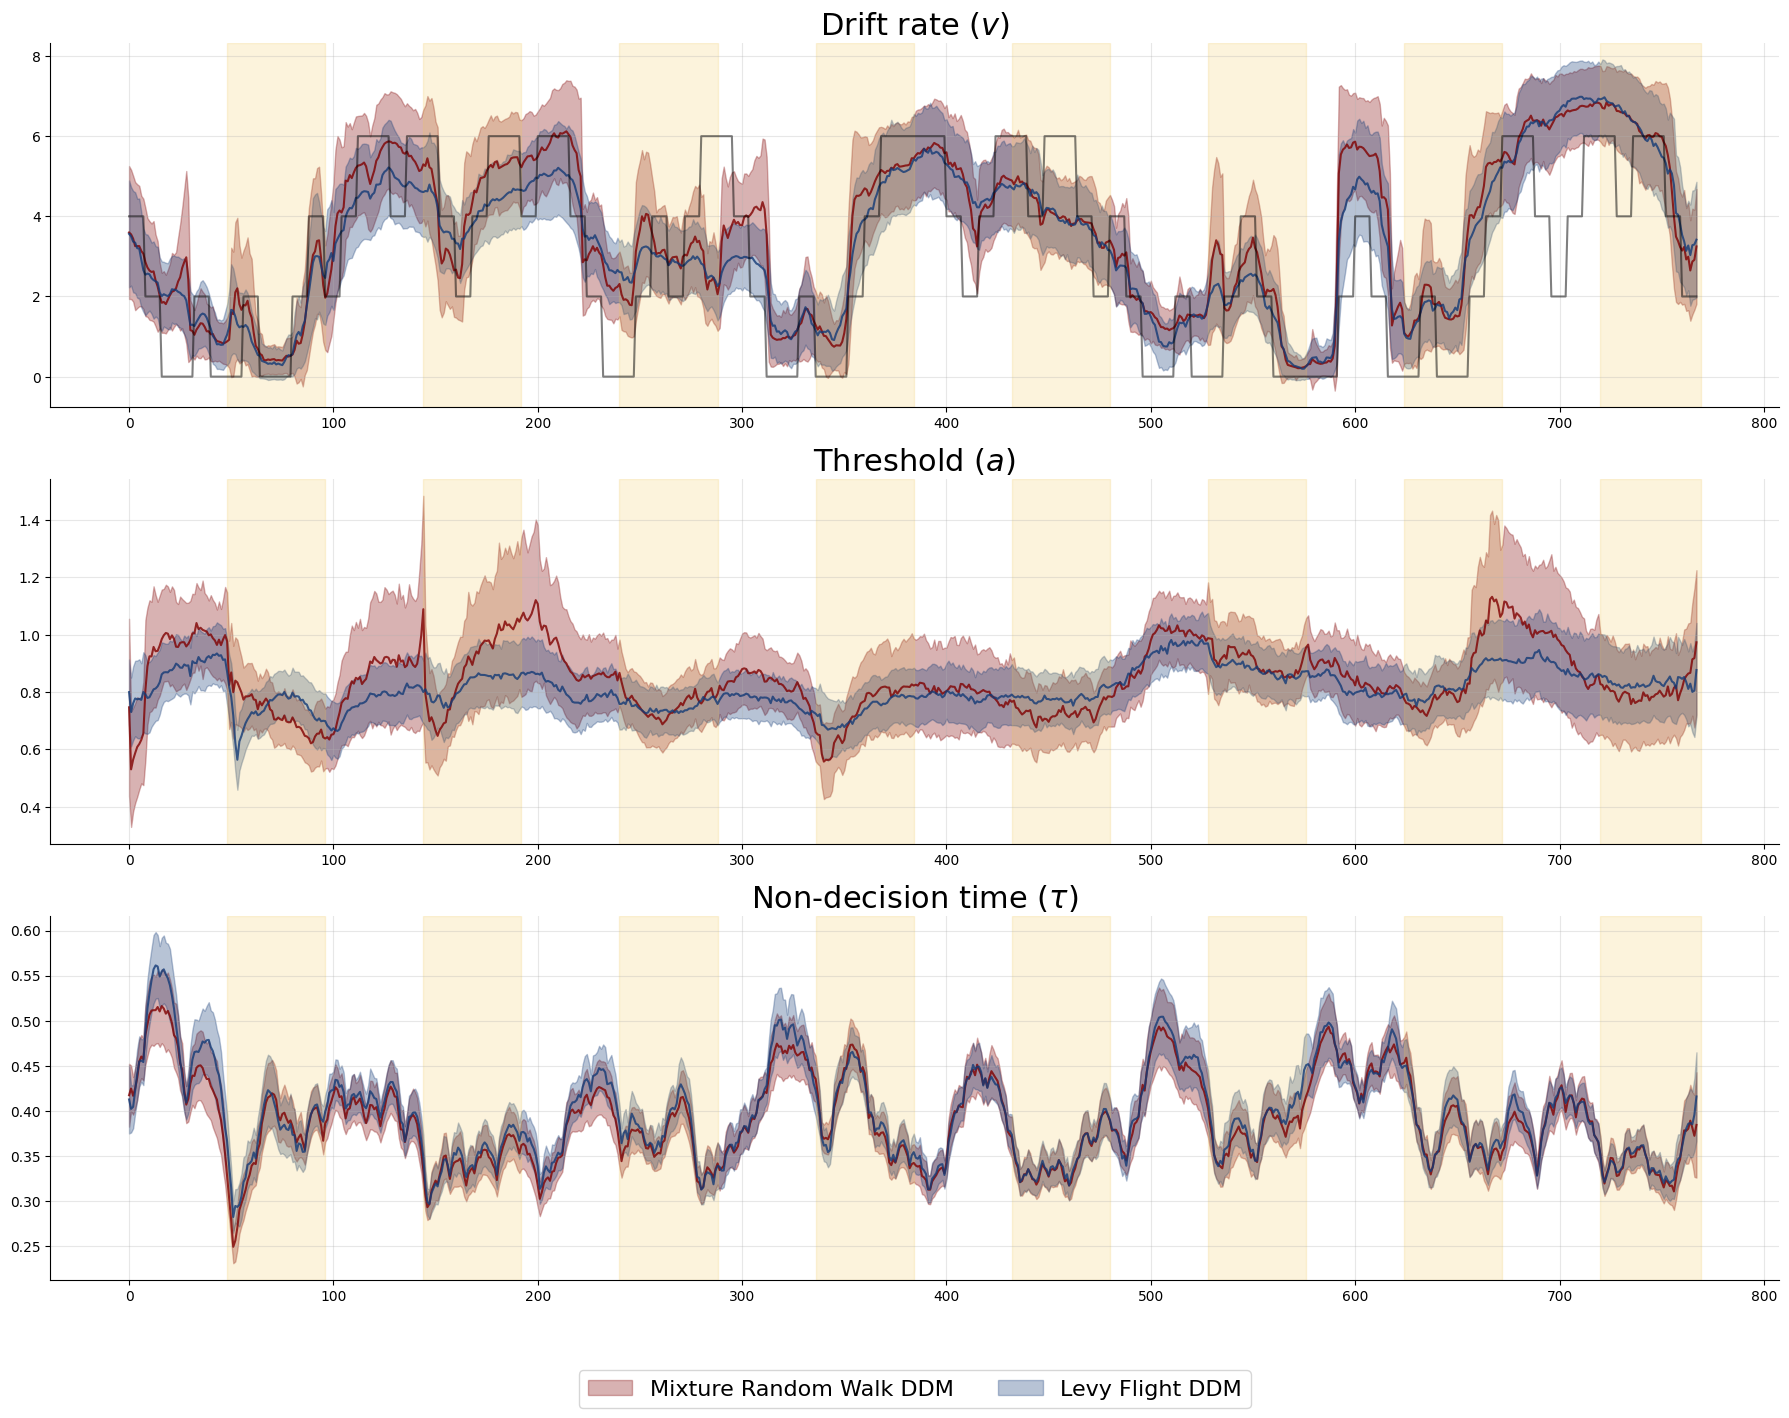

In [67]:
fig, axarr = plt.subplots(3, 1, figsize=(18, 14))
for i, ax in enumerate(axarr.flat):
    ax.fill_between(range(NUM_OBS), smoothing_post_mean[:, i] - smoothing_post_std[:, i],
                    smoothing_post_mean[:, i] + smoothing_post_std[:, i],
                    color='maroon', alpha=0.3, label="Mixture Random Walk DDM")
    ax.plot(range(NUM_OBS), smoothing_post_mean[:, i], color='maroon', alpha=0.8)

    ax.fill_between(range(NUM_OBS), lf_post_mean[:, i] - lf_post_std[:, i],
                    lf_post_mean[:, i] + lf_post_std[:, i],
                    color=COMPARISON_COLOR, alpha=0.3, label="Levy Flight DDM")
    ax.plot(range(NUM_OBS), lf_post_mean[:, i], color=COMPARISON_COLOR, alpha=0.8)

    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)

        # stan
        # ax.fill_between(range(NUM_OBS), stan_post_means[:, i-1] - stan_post_stds[:, i-1],
        #                 stan_post_means[:, i-1] + stan_post_stds[:, i-1],
        #                 color=COMPARISON_COLOR, alpha=0.3, label="Stationary DDM")
        # ax.plot(range(N_OBS), stan_post_means[:, i-1], color=COMPARISON_COLOR, alpha=0.8)
    
    x = 0
    while x < idx_speed.shape[0]:
        ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654')
        x = x + 2
    
    ax.grid(alpha=0.3)
    
    if i == 2:
        plt.subplots_adjust(hspace=0.5)
        plt.legend(fontsize=16, loc='center', 
                bbox_to_anchor=(0.5, -0.3), ncol=2)
axarr[0].plot(range(NUM_OBS), (person_data['difficulty'] - 3) * -2, color='black', alpha=0.5)
sns.despine()
fig.tight_layout()
# plt.savefig("../plots/param_dynamics.png", dpi=300, bbox_inches="tight")

In [ ]:
# if FIT_MODELS:
#     mrw_local_post_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
#     mrw_hyper_post_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
#     lf_local_post_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
#     lf_hyper_post_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
#     rs_local_post_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
#     rs_hyper_post_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))

#     with tf.device('/cpu:0'):
#         for i in range(NUM_SUBJECTS):
#             tmp_data = {'summary_conditions': emp_data[i:i+1]}
#             samples = mixture_random_walk_experiment.amortizer.sample(tmp_data, NUM_SAMPLES)
#             mrw_local_post_samples_z[i] = samples['local_samples']
#             mrw_hyper_post_samples_z[i] = samples['global_samples']
#             samples = levy_flight_experiment.amortizer.sample(tmp_data, NUM_SAMPLES)
#             lf_local_post_samples_z[i] = samples['local_samples']
#             lf_hyper_post_samples_z[i] = samples['global_samples']
#             samples = regime_switching_experiment.amortizer.sample(tmp_data, NUM_SAMPLES)
#             rs_local_post_samples_z[i] = samples['local_samples']
#             rs_hyper_post_samples_z[i] = samples['global_samples']

#     mrw_local_post_samples = mrw_local_post_samples_z * mixture_random_walk_model.local_prior_stds + mixture_random_walk_model.local_prior_means
#     mrw_hyper_post_samples = mrw_hyper_post_samples_z * mixture_random_walk_model.hyper_prior_std + mixture_random_walk_model.hyper_prior_mean
#     lf_local_post_samples = lf_local_post_samples_z * levy_flight_model.local_prior_stds + levy_flight_model.local_prior_means
#     lf_hyper_post_samples = lf_hyper_post_samples_z * levy_flight_model.hyper_prior_std + levy_flight_model.hyper_prior_mean
#     rs_local_post_samples = rs_local_post_samples_z * regime_switching_model.local_prior_stds + regime_switching_model.local_prior_means
#     rs_hyper_post_samples = rs_hyper_post_samples_z * regime_switching_model.hyper_prior_std + regime_switching_model.hyper_prior_mean

#     with open('../data/posteriors/mrw_local_post_samples.pkl', 'wb') as f:
#         pickle.dump(mrw_local_post_samples, f)
#     with open('../data/posteriors/mrw_hyper_post_samples.pkl', 'wb') as f:
#         pickle.dump(mrw_hyper_post_samples, f)
#     with open('../data/posteriors/lf_local_post_samples.pkl', 'wb') as f:
#         pickle.dump(lf_local_post_samples, f)
#     with open('../data/posteriors/lf_hyper_post_samples.pkl', 'wb') as f:
#         pickle.dump(lf_hyper_post_samples, f)
#     with open('../data/posteriors/rs_local_post_samples.pkl', 'wb') as f:
#         pickle.dump(rs_local_post_samples, f)
#     with open('../data/posteriors/rs_hyper_post_samples.pkl', 'wb') as f:
#         pickle.dump(rs_hyper_post_samples, f)
# else:
#     with open('../data/posteriors/mrw_local_post_samples.pkl', 'rb') as f:
#         mrw_local_post_samples = pickle.load(f)
#     with open('../data/posteriors/mrw_hyper_post_samples.pkl', 'rb') as f:
#         mrw_hyper_post_samples = pickle.load(f)
#     with open('../data/posteriors/lf_local_post_samples.pkl', 'rb') as f:
#         lf_local_post_samples = pickle.load(f)
#     with open('../data/posteriors/lf_hyper_post_samples.pkl', 'rb') as f:
#         lf_hyper_post_samples = pickle.load(f)
#     with open('../data/posteriors/rs_local_post_samples.pkl', 'rb') as f:
#         rs_local_post_samples = pickle.load(f)
#     with open('../data/posteriors/rs_hyper_post_samples.pkl', 'rb') as f:
#         rs_hyper_post_samples = pickle.load(f)